In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive/')

import torch
torch.cuda.is_available()

os.chdir('/content/drive/MyDrive/Colab Notebooks/SeFa')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive/


# Define Utility Functions

In [ ]:
#@title
import os.path
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image

import torch

from models import parse_gan_type
from utils import to_tensor
from utils import postprocess
from utils import load_generator
from utils import factorize_weight


def sample(generator, gan_type, num=1, seed=0):
    """Samples latent codes."""
    torch.manual_seed(seed)
    codes = torch.randn(num, generator.z_space_dim).to(device)
    if gan_type == 'pggan':
        codes = generator.layer0.pixel_norm(codes)
    elif gan_type == 'stylegan':
        codes = generator.mapping(codes)['w']
        codes = generator.truncation(codes, trunc_psi=0.7, trunc_layers=8)
    elif gan_type == 'stylegan2':
        codes = generator.mapping(codes)['w']
        codes = generator.truncation(codes, trunc_psi=0.5, trunc_layers=18)
    codes = codes.detach().cpu().numpy()
    return codes


def synthesize(generator, gan_type, codes):
    """Synthesizes images with the give codes."""
    if gan_type == 'pggan':
        images = generator(to_tensor(codes))['image']
    elif gan_type in ['stylegan', 'stylegan2']:
        images = generator.synthesis(to_tensor(codes))['image']
    images = postprocess(images)
    return images


def imshow(images, col, viz_size=256):
    """Shows images in one figure."""
    num, height, width, channels = images.shape
    assert num % col == 0
    row = num // col

    fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

    for idx, image in enumerate(images):
        i, j = divmod(idx, col)
        y = i * viz_size
        x = j * viz_size
        if height != viz_size or width != viz_size:
            image = cv2.resize(image, (viz_size, viz_size))
        fused_image[y:y + viz_size, x:x + viz_size] = image

    fused_image = np.asarray(fused_image, dtype=np.uint8)
    data = io.BytesIO()
    PIL.Image.fromarray(fused_image).save(data, 'jpeg')
    im_data = data.getvalue()
    disp = IPython.display.display(IPython.display.Image(im_data))
    return disp

# Select a Model

In [ ]:
#@title { display-mode: "form", run: "auto" }
model_name = "stylegan_ffhq512" #@param ['stylegan_animeface512', 'stylegan_car512', 'stylegan_cat256', 'pggan_celebahq1024', 'stylegan_bedroom256', 'stylegan_ffhq512', 'stylegan2_ffhq1024']

generator = load_generator(model_name)
gan_type = parse_gan_type(generator)

Building generator for model `stylegan_ffhq512` ...
Finish building generator.
Loading checkpoint from `checkpoints/stylegan_ffhq512.pth` ...
Finish loading checkpoint.


# Sample Latent Codes

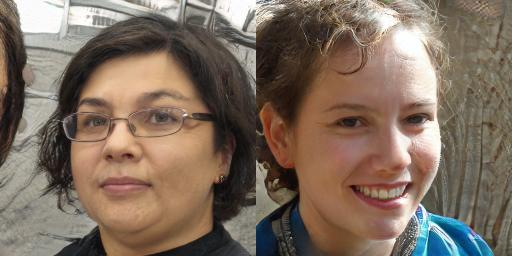

In [ ]:
#@title { display-mode: "form", run: "auto" }

num_samples = 2 #@param {type:"slider", min:1, max:8, step:1}
noise_seed = 0 #@param {type:"slider", min:0, max:1000, step:1}

codes = sample(generator, gan_type, num_samples, noise_seed)
images = synthesize(generator, gan_type, codes)
imshow(images, col=num_samples)

# Factorize & Edit

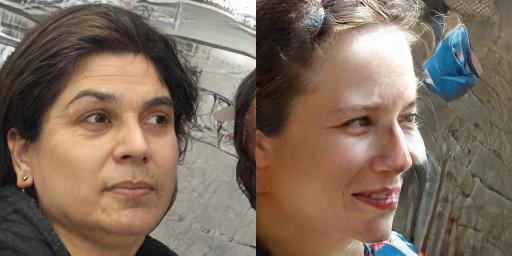

In [ ]:
#@title { display-mode: "form", run: "auto" }

layer_idx = "0-1" #@param ['all', '0-1', '2-5', '6-13']
semantic_1 = 3 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_2 = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_3 = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_4 = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_5 = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}

# Fast implementation to factorize the weight by SeFa.
layers, boundaries, _ = factorize_weight(generator, layer_idx)

new_codes = codes.copy()
for sem_idx in range(5):
    boundary = boundaries[sem_idx:sem_idx + 1]
    step = eval(f'semantic_{sem_idx + 1}')
    if gan_type == 'pggan':
        new_codes += boundary * step
    elif gan_type in ['stylegan', 'stylegan2']:
        new_codes[:, layers, :] += boundary * step
new_images = synthesize(generator, gan_type, new_codes)
imshow(new_images, col=num_samples)

# Sampling with correlation to the classes

In [ ]:
%run main_correlation_estimator.py stylegan2_ffhq1024 -L 8-12 -N 3 -K 5 --start_distance=-3 --end_distance=3 --step=7 --classifier_model_path=classifier/ft_model_epoch_8.pth

Building generator for model `stylegan2_ffhq1024` ...
Finish building generator.
Loading checkpoint from `checkpoints/stylegan2_ffhq1024.pth` ...
Finish loading checkpoint.


Sample : 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


----- eigen-vector id  0
class :  Attractive , CC :  0.8132117912843274
class :  Bald , CC :  -0.7771339791251184
class :  Bangs , CC :  0.7870389149559942
class :  Blurry , CC :  -0.7746197528700761
class :  High_Cheekbones , CC :  0.8368086188199901
class :  Mouth_Slightly_Open , CC :  0.9159415736555373
class :  Mustache , CC :  -0.783535327050394
class :  Narrow_Eyes , CC :  0.754605355885108
class :  No_Beard , CC :  0.7767346770726847
class :  Oval_Face , CC :  0.9351993010555892
class :  Receding_Hairline , CC :  -0.9016345870468702
----- eigen-vector id  1
class :  Arched_Eyebrows , CC :  0.9551419976317443
class :  Attractive , CC :  0.8239015163276632
class :  Big_Lips , CC :  0.8588160003848073
class :  Blurry , CC :  -0.8784091069341341
class :  Brown_Hair , CC :  0.8447100773863836
class :  Bushy_Eyebrows , CC :  0.8236296108634281
class :  Double_Chin , CC :  0.8091646487087464
class :  Heavy_Makeup , CC :  0.9415095128840388
class :  Narrow_Eyes , CC :  -0.89050432446819

In [ ]:
%%sh run.sh